# Timeseries calculation with Temperature-Dependent Power Flow (TDPF)

With the TDPF calculation, the resulting overhead line temperature appears in the net.res_line table. This means that the line temperature is always initialized with 20 °C. If the TDPF is calculated for steady-state conditions, which is a valid approach for the time steps of ~1 hour, there is no need for any special consideration of the initial line temperature.

However, if shorter time steps are used, e.g. 15 min, thermal inertia must be considered. The resulting temperature from the previous time step needs to be used as the starting temperature for the next tinme step. To achieve this, the value from net.res_line.temperature_degree_celsius must be written in net.line.temperature_degree_celsius. The reference temperature for calculating the resistance is not impacted by this change because it is stored in a separate column in net.line.reference_temperature_degree_celsius.

In order to write the value of temperature_degree_celsius in the net.line table, a special controller must be added. In this tutorial we will demonstrate it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandapower as pp
import pandapower.control
import pandapower.timeseries

from pandapower.control.basic_controller import Controller

from pandapower.test.loadflow.test_tdpf import simple_test_grid

In [2]:
class TDPF_timeseries_control(Controller):
    def is_converged(self, net):
        return True
    
    def finalize_step(self, net, time_step):
        net.line.loc[net.line.tdpf, "temperature_degree_celsius"] = \
            net.res_line.loc[net.line.tdpf, "temperature_degree_celsius"]

# Wind speed data

We demonstrate the timeseries simulation just by modifying the wind speed data, all other inputs will remain the same. Having just one variation makes it easier to understand the demonstrated effect. In a productive application of the demonstrated approach, both the weather data (wind speed, air temperature, solar radiation) and the grid-related data (power of consumption and generation) would vary with the time steps.

Below we show the wind speed profile that we use in the example:

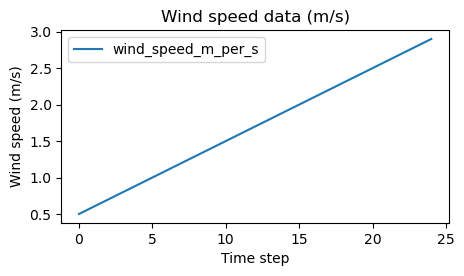

In [3]:
data = pd.DataFrame(columns=["wind_speed_m_per_s"], data=np.arange(0.5, 3, 0.1), index=np.arange(25, dtype=np.int64))
ax = data.plot(figsize=(5, 2.5))
ax.set_title("Wind speed data (m/s)")
ax.set_ylabel("Wind speed (m/s)")
ax.set_xlabel("Time step");

# Time-series simulation

A simple grid example is used to demonstrate the time-series calculation. We use the same grid model as in the other tutorials related to TDPF. 

The grid is created with all the relevant TDPF parameters. The wind speed profile is applied via ConstControl. The following calculations are executed:

* time-series calculation with steady-state TDPF. The thermal inertia effect is disregarded.
* time-series calculation with the thermal inertia for the time delay of 10 min. This represents the time resolution of the time-series calculation of 10 min. The starting temperature of the lines is always 20 °C, at every time step
* similar calculation as in the previous case, except that the result of the previous time step is used to set up the starting temperature for every time step.

In [4]:
net = simple_test_grid(load_scaling=0.25, sgen_scaling=0.5, with_gen=True, distributed_slack=False)

In [5]:
ds = pp.timeseries.DFData(data)
pp.control.ConstControl(net, "line", "wind_speed_m_per_s", net.line.query("tdpf").index, "wind_speed_m_per_s", ds, recycle=False)
ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_line", "temperature_degree_celsius")
ow.log_variable("line", "wind_speed_m_per_s")

In [6]:
pp.timeseries.run_timeseries(net, time_steps=range(25), tdpf=True, max_iteration=50)
output_ss = ow.output["res_line.temperature_degree_celsius"].copy()
pp.timeseries.run_timeseries(net, time_steps=range(25), tdpf=True, tdpf_delay_s=15*60, max_iteration=50)
output_ss_20 = ow.output["res_line.temperature_degree_celsius"].copy()
pp.timeseries.run_timeseries(net, time_steps=range(25), tdpf=True, tdpf_delay_s=5*60, max_iteration=50)
output_ss_20_5 = ow.output["res_line.temperature_degree_celsius"].copy()

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 21.96it/s]


In [7]:
TDPF_timeseries_control(net)
net.line.temperature_degree_celsius = 20
pp.timeseries.run_timeseries(net, time_steps=range(25), tdpf=True, tdpf_delay_s=15*60, max_iteration=50)
output_15 = ow.output["res_line.temperature_degree_celsius"].copy()
net.line.temperature_degree_celsius = 20
pp.timeseries.run_timeseries(net, time_steps=range(25), tdpf=True, tdpf_delay_s=5*60, max_iteration=50)
output_5 = ow.output["res_line.temperature_degree_celsius"].copy()

hp.pandapower.control.util.auxiliary - INFO: Creating controller 1 of type <class '__main__.TDPF_timeseries_control'> 
100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 11.96it/s]


# Results

We compare the line temperature from the time-series calculation results for termal inertia consideration with the steady-state variant. The calculation in which the starting temperature is always 20 °C has unrealistic results. 

The calculation that considers the temperature from the previous time steps as the initial line temperature has a more interesting result. The calculation starts with line temperature of 20 °C, and it slowly increases. This shows the impact of thermal inertia on the results. Afterwards, as the wind speed increases and the cooling of lines becomes stronger, the line temperature tracks above the steady-state temperature.

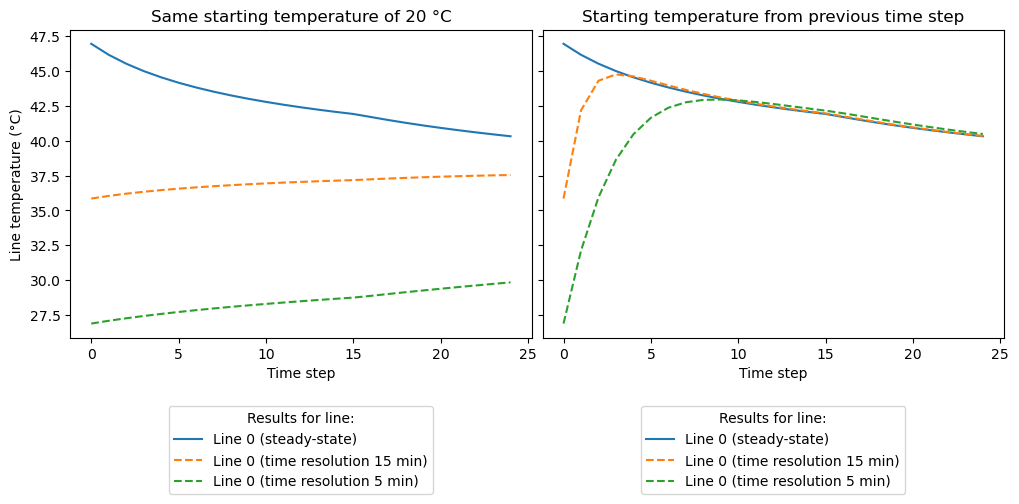

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
output_ss[0].plot(ax=ax1, label="Line 0 (steady-state)")
output_ss_20[0].plot(ax=ax1, linestyle="--", label="Line 0 (time resolution 15 min)")
output_ss_20_5[0].plot(ax=ax1, linestyle="--", label="Line 0 (time resolution 5 min)")
ax1.legend(title="Results for line:", loc="upper center", bbox_to_anchor=[0.5,-0.2])

output_ss[0].plot(ax=ax2, label="Line 0 (steady-state)")
output_15[0].plot(ax=ax2, linestyle="--", label="Line 0 (time resolution 15 min)")
output_5[0].plot(ax=ax2, linestyle="--", label="Line 0 (time resolution 5 min)")
ax2.legend(title="Results for line:", loc="upper center", bbox_to_anchor=[0.5,-0.2])

ax1.set_ylabel("Line temperature (°C)")
ax1.set_xlabel("Time step")
ax2.set_xlabel("Time step")

ax1.set_title("Same starting temperature of 20 °C")
ax2.set_title("Starting temperature from previous time step")
plt.tight_layout(pad=0)

With the increase of the wind speed, the cooling effect becomes stronger, and the steady-state temperature of the line is reduced. 

When the starting temperature is constant, and thermal inertia is considered for a given time resolution (15 min and 5 min), the results are misleading. The line temperature does not reach the results of the steady-state calculation even after supposedly 1 h of time delay.

In the second case study the starting line temperature is set from the results of the previous time step (except for the very first time step with the starting temperature of 20 °C). The results show that the line temperature reaches the values of the steady-state calculation after several time steps. The curve representing the time resolution of 15 min (1 hour is equivalent to 4 time steps) crosses the curve of the steady-state calculation at the fifth time step. For the resolution of 5 min (1 hour is equivalent to 12 time steps), the crossing happens at the 11th time step. In both cases, the curve with thermal inertia catches up with the steady-state curve after about 1 hour. Therefore, considering thermal inertia is relevant for time series simulation with the time resolution of less than 1 hour.